In [1]:
#!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 36.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from numpy import linalg as lg
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import torch
import torch.nn as nn
from torch.autograd import Variable

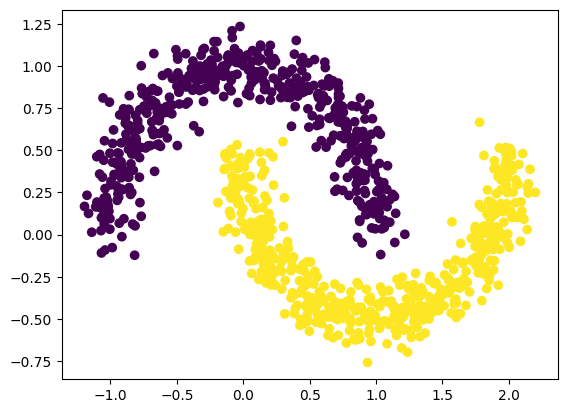

In [3]:
from sklearn.datasets import make_moons

sample_size = 1000

X, Y = make_moons(n_samples=sample_size, noise=0.1, random_state=100)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')
plt.show()

In [4]:
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)

In [16]:
qubits = 4
depth = 2
dev = qml.device("lightning.qubit", wires=qubits)

def angle_embedding(inputs):
  for i in range(qubits):
    qml.Hadamard(wires=i)

  for i in range(qubits):
    qml.RY(inputs[2*i], wires = i)
    qml.RZ(inputs[2*i + 1], wires = i)

def amplitude_embedding(data):
  normalize_input = data/np.linalg.norm(data)
  qml.templates.AmplitudeEmbedding(features=data, wires=range(qubits), pad_with=0.0, normalize=True)


embedding1 = angle_embedding
embedding2 = amplitude_embedding


@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

  embedding1(inputs)
  # embedding2(inputs)

  for i in range(depth):
    for j in range(qubits):
      qml.RX(weights[2 * (i * qubits + j)], wires = j)
      qml.RY(weights[2 * (i * qubits + j) + 1], wires = j)
    for k in range(qubits):
      if (k != qubits - 1):
        qml.CNOT(wires=[k,k+1])
      else:
        qml.CNOT(wires=[k,0])



    # Measurement
  return [qml.expval(qml.PauliZ(wires=i)) for i in range(qubits)]

In [17]:
n_args =  2*(depth +1) * qubits
weight_shapes = {"weights": n_args}


In [18]:
print(qml.draw(qnode)(inputs = np.random.rand(qubits * 2), weights = np.random.rand(n_args)))

0: ──H──RY(0.56)──RZ(0.57)──RX(0.48)──RY(0.37)─╭●───────╭X──RX(0.55)──RY(0.46)─╭●───────╭X─┤  <Z>
1: ──H──RY(0.58)──RZ(0.86)──RX(0.04)──RY(0.95)─╰X─╭●────│───RX(0.96)──RY(0.08)─╰X─╭●────│──┤  <Z>
2: ──H──RY(0.56)──RZ(0.11)──RX(0.84)──RY(0.15)────╰X─╭●─│───RX(0.41)──RY(0.05)────╰X─╭●─│──┤  <Z>
3: ──H──RY(0.15)──RZ(0.47)──RX(0.82)──RY(0.16)───────╰X─╰●──RX(0.54)──RY(0.26)───────╰X─╰●─┤  <Z>


In [19]:
class QNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.qlayer_1(dout[0])
        h2 = self.relu2(a2.unsqueeze(0))
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
# .detach().numpy()
# torch.tensor(a2)
qnet = QNet()

In [20]:
def train_epoch(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss)
    return losses

In [21]:
import time
# Define Optimizer and loss function
q_opt = torch.optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()

start = time.time()
e_losses_q = []
num_epochs = 10
for e in range(num_epochs):
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    if (e % 10 == 0):
        print(e)
#plt.plot(e_losses_q)
end = time.time()

0


In [22]:
print("Execution time", end - start)

Execution time 83.36977815628052


In [23]:
test_pred_q = torch.empty((sample_size,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))

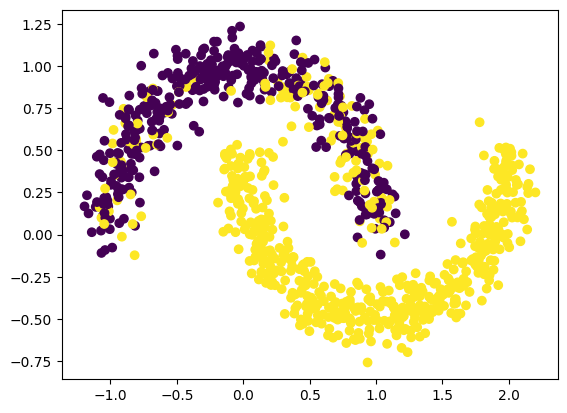

In [24]:
plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy(), cmap='viridis')

In [25]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc
accuracy_fn(y, test_pred_q)

87.6